In [15]:
import sqlite3
from io import BytesIO

import numpy as np
from PIL import Image
from keras import Input


def load_data_from_db(test, target_size=(128, 128)):
    conn = sqlite3.connect('images.db')
    cursor = conn.cursor()
    cursor.execute("SELECT imagine, sepia FROM Imagini WHERE test = ?", (True if test == 1 else False,))
    rows = cursor.fetchall()
    conn.close()

    x = []
    y = []
    for row in rows:
        imagine_blob, sepia = row
        imagine_bytes = BytesIO(imagine_blob)
        imagine = Image.open(imagine_bytes)

        if imagine.mode == "P":
            imagine = imagine.convert("RGBA")
        if imagine.mode != 'RGB':
            imagine = imagine.convert('RGB')

        imagine = imagine.resize(target_size)

        imagine = np.array(imagine) / 255.0

        x.append(imagine)
        y.append(1 if sepia else 0)

    x = np.array(x)
    y = np.array(y)
    return x, y


In [16]:
train_input, train_output = load_data_from_db(0)
test_input, test_output = load_data_from_db(1)

In [17]:
from keras.src.optimizers import Adam

input_shape = train_input.shape[1:]

from tensorflow.keras import layers, models

model = models.Sequential([
    Input(input_shape),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])



model.fit(train_input, train_output, epochs=10)

predicted = model.predict(test_input)
predicted = [1 if p > 0.5 else 0 for p in predicted]

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.4656 - loss: 0.7019 - precision: 0.3864 - recall: 0.5049
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7292 - loss: 0.6649 - precision: 0.7914 - recall: 0.6197
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8385 - loss: 0.6119 - precision: 0.7569 - recall: 0.9677
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8302 - loss: 0.5575 - precision: 0.7417 - recall: 1.0000
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8292 - loss: 0.4939 - precision: 0.7448 - recall: 1.0000
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8521 - loss: 0.4301 - precision: 0.7796 - recall: 1.0000
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8677 - loss: 0.3632 - precision: 0.8000 - recall: 0.9937
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.8510 - loss: 0.3473 - precision: 0.8088 - recall: 0.9374
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━

In [18]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,803,141 (37.40 MB)

 Trainable params: 3,267,713 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,535,428 (24.93 MB)

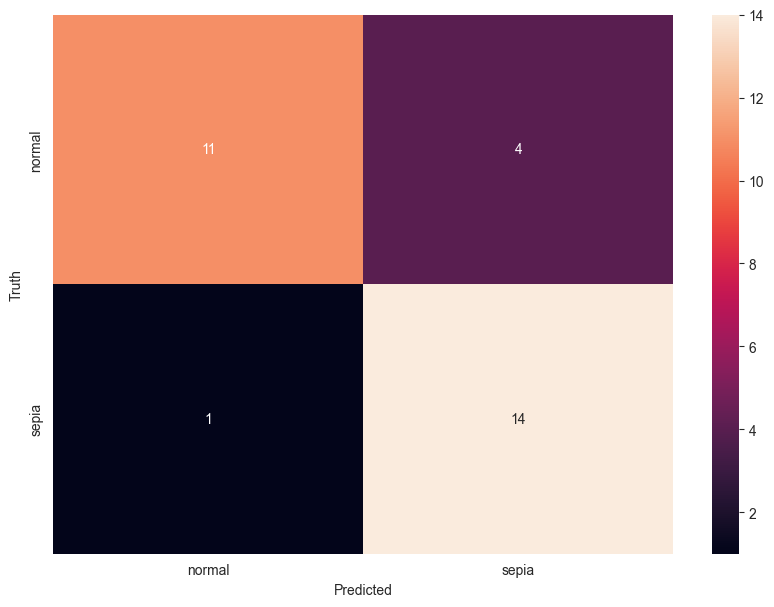

In [19]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_output, predicted)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["normal", "sepia"], yticklabels=["normal", "sepia"])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [20]:
model2 = models.Sequential([
    Input(input_shape),
    layers.Conv2D(64, (4, 4), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid')
])


In [21]:
model2.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

model2.fit(train_input, train_output, epochs=10)

predicted = model2.predict(test_input)
predicted = [1 if p > 0.5 else 0 for p in predicted]

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 593ms/step - accuracy: 0.4302 - loss: 1.0920 - precision: 0.4525 - recall: 0.3479
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 597ms/step - accuracy: 0.5604 - loss: 0.9347 - precision: 0.5610 - recall: 0.4829
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 618ms/step - accuracy: 0.5792 - loss: 0.8116 - precision: 0.6025 - recall: 0.5670
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 587ms/step - accuracy: 0.7448 - loss: 0.5559 - precision: 0.7571 - recall: 0.7303
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step - accuracy: 0.7271 - loss: 0.5571 - precision: 0.8021 - recall: 0.6572
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 570ms/step - accuracy: 0.7583 - loss: 0.4863 - precision: 0.7836 - recall: 0.7565
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 564ms/step - accuracy: 0.7396 - loss: 0.5339 - precision: 0.7529 - recall: 0.7314
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 564ms/step - accuracy: 0.8271 - loss: 0.3778 - precision: 0.8196 - recall: 0.8431
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━

In [22]:
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 125, 125, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,240,389 (84.84 MB)

 Trainable params: 7,413,377 (28.28 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 14,826,756 (56.56 MB)

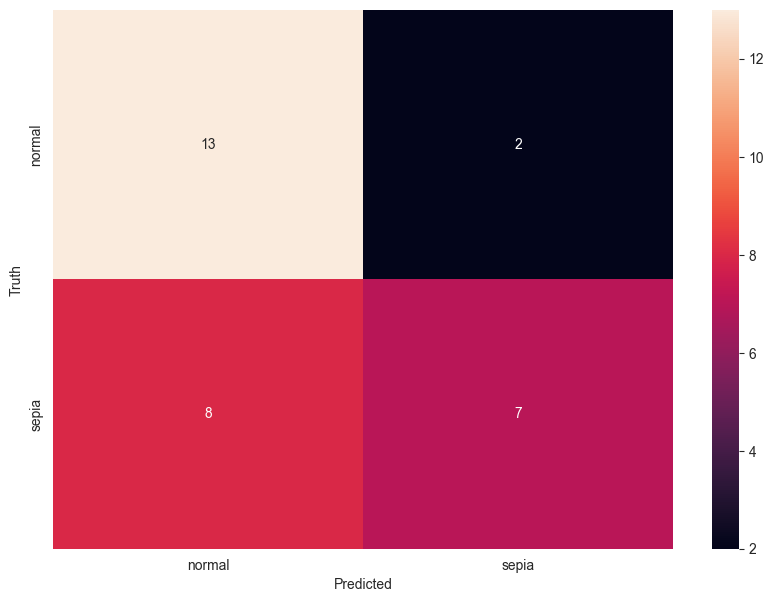

In [23]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_output, predicted)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["normal", "sepia"], yticklabels=["normal", "sepia"])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()